# Dependencies

In [1]:
!git clone https://github.com/voxelmorph/voxelmorph.git # getting vxm from git to use scripts
!pip install neurite

Cloning into 'voxelmorph'...
remote: Enumerating objects: 3228, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 3228 (delta 8), reused 15 (delta 6), pack-reused 3202
Receiving objects: 100% (3228/3228), 129.18 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (2072/2072), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.3-py3-none-any.whl size=19549 sha256=29446edbaeab7a743f442d8ae2ef2953b7818d44cba57bc733ffb07dc68ed303
  Stored in directory: /root/.cache/pip/wheels/33/42/e2/6312e2cd3efadacc2714759efc7c7dc1513db7853e8bd508f6
Successfully built pystrum


In [2]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne
import sys 
sys.path.append('voxelmorph')
import voxelmorph as vxm
import time

import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

np.random.seed(777)
tf.random.set_seed(777)

# disable eager execution
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True) # https://github.com/tensorflow/tensorflow/issues/54458


# Connect to driver

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Download dataset OASIS

In [5]:
# get neurite-OASIS data
!wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
!mkdir OASIS
!tar xf neurite-oasis.2d.v1.0.tar --directory 'OASIS'

# !wget https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.v1.0.tar
# !mkdir OASIS
# !tar xf neurite-oasis.v1.0.tar --directory 'OASIS'

--2023-05-09 13:32:00--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘neurite-oasis.2d.v1.0.tar’

neurite-oasis.2d.v1 100%[===================>]  23.75M  8.67MB/s    in 2.7s    

2023-05-09 13:32:04 (8.67 MB/s) - ‘neurite-oasis.2d.v1.0.tar’ saved [24903680/24903680]



In [6]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]

train = subj_lst_m[:int(0.7 * len(subj_lst_m))]
validate = subj_lst_m[int(0.7 * len(subj_lst_m)):]

with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(train))

# Train

Epoch 1/1000
100/100 [==============================] - 22s 28ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_resize_loss: 1.3407e-04
Epoch 2/1000
100/100 [==============================] - 3s 30ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0066 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_resize_loss: 0.0042
Epoch 3/1000
100/100 [==============================] - 3s 27ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0060 - vxm_dense_transformer_loss: 0.0058 - vxm_dense_flow_resize_loss: 0.0211
Epoch 4/1000
100/100 [==============================] - 3s 27ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0049 - vxm_dense_transformer_loss: 0.0044 - vxm_dense_flow_resize_loss: 0.0482
Epoch 5/1000
100/100 [==============================] - 3s 27ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0045 - vxm_dense_transformer_loss: 0.0040 - vxm_dense_flow_resize_loss: 0.0539
Epoch 6/1000
100/100 [=======================

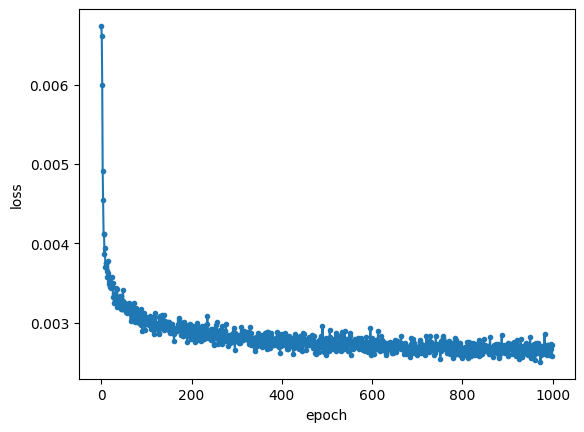

In [7]:
# training parameters
class Args:
  img_list: str = 'train_list.txt'
  img_prefix: str = None
  img_suffix: str = None
  atlas: str = None
  model_dir: str = 'models'
  multichannel: bool = False
  gpu: int = 0
  batch_size: int = 1
  epochs: int = 1500
  steps_per_epoch: int = 100
  load_weights: str = None
  initial_epoch: int = 0
  lr: float = 1e-4
  enc: list = None
  dec: list = None
  int_steps: int = 7
  int_downsize: int = 2
  use_probs: bool = False
  bidir: bool = False
  image_loss: str = 'mse'
  lambda_weight: float = 0.01
  kl_lambda: float = 10
  image_sigma: float = 1.0

args = Args()
args.epochs = 1000

# load and prepare training data
train_files = vxm.py.utils.read_file_list(args.img_list, prefix=args.img_prefix,
                                          suffix=args.img_suffix)
assert len(train_files) > 0, 'Could not find any training data.'

# no need to append an extra feature axis if data is multichannel
add_feat_axis = not args.multichannel

if args.atlas:
    # scan-to-atlas generator
    atlas = vxm.py.utils.load_volfile(args.atlas, np_var='vol',
                                      add_batch_axis=True, add_feat_axis=add_feat_axis)
    generator = vxm.generators.scan_to_atlas(train_files, atlas,
                                             batch_size=args.batch_size,
                                             bidir=args.bidir,
                                             add_feat_axis=add_feat_axis)
else:
    # scan-to-scan generator
    generator = vxm.generators.scan_to_scan(
        train_files, batch_size=args.batch_size, bidir=args.bidir, add_feat_axis=add_feat_axis)

# extract shape and number of features from sampled input
sample_shape = next(generator)[0][0].shape
inshape = sample_shape[1:-1]
nfeats = sample_shape[-1]

# prepare model folder
model_dir = args.model_dir
os.makedirs(model_dir, exist_ok=True)

# tensorflow device handling
device, nb_devices = vxm.tf.utils.setup_device(args.gpu)
assert np.mod(args.batch_size, nb_devices) == 0, \
    'Batch size (%d) should be a multiple of the nr of gpus (%d)' % (args.batch_size, nb_devices)

# unet architecture
enc_nf = args.enc if args.enc else [16, 32, 32, 32]
dec_nf = args.dec if args.dec else [32, 32, 32, 32, 32, 16, 16]

# prepare model checkpoint save path
save_filename = os.path.join(model_dir, '{epoch:04d}.h5')

# build the model
model = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=args.bidir,
    use_probs=args.use_probs,
    int_steps=args.int_steps,
    int_resolution=args.int_downsize,
    src_feats=nfeats,
    trg_feats=nfeats
)

# load initial weights (if provided)
if args.load_weights:
    model.load_weights(args.load_weights)

# prepare image loss
if args.image_loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.image_loss == 'mse':
    image_loss_func = vxm.losses.MSE(args.image_sigma).loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

# need two image loss functions if bidirectional
if args.bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]

# prepare deformation loss
if args.use_probs:
    flow_shape = model.outputs[-1].shape[1:-1]
    losses += [vxm.losses.KL(args.kl_lambda, flow_shape).loss]
else:
    losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]

weights += [args.lambda_weight]

# multi-gpu support
if nb_devices > 1:
    save_callback = vxm.networks.ModelCheckpointParallel(save_filename)
    model = tf.keras.utils.multi_gpu_model(model, gpus=nb_devices)
else:
    save_callback = tf.keras.callbacks.ModelCheckpoint(save_filename, 
                                                       save_freq=20 * args.steps_per_epoch)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=args.lr), loss=losses, loss_weights=weights)

# save starting weights
# model.save(save_filename.format(epoch=args.initial_epoch))

hist = model.fit(generator,
         initial_epoch=args.initial_epoch,
         epochs=args.epochs,
         steps_per_epoch=args.steps_per_epoch,
         callbacks=[save_callback],
         verbose=1
        )

# saving the model in tensorflow format
model.save(f'./{args.epochs}_tf',save_format='tf')

# plot training history.
plt.figure()
plt.plot(hist.epoch, hist.history['loss'], '.-')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
!zip -r 1000-epoch-models.zip /content/models/
!zip -r 1000-tf.zip /content/1000_tf/

  adding: content/models/ (stored 0%)
  adding: content/models/0280.h5 (deflated 15%)
  adding: content/models/0320.h5 (deflated 15%)
  adding: content/models/0380.h5 (deflated 15%)
  adding: content/models/0860.h5 (deflated 15%)
  adding: content/models/0160.h5 (deflated 15%)
  adding: content/models/0140.h5 (deflated 15%)
  adding: content/models/0340.h5 (deflated 15%)
  adding: content/models/0880.h5 (deflated 15%)
  adding: content/models/0360.h5 (deflated 15%)
  adding: content/models/0100.h5 (deflated 15%)
  adding: content/models/0700.h5 (deflated 15%)
  adding: content/models/1000.h5 (deflated 15%)
  adding: content/models/0480.h5 (deflated 15%)
  adding: content/models/0900.h5 (deflated 15%)
  adding: content/models/0220.h5 (deflated 15%)
  adding: content/models/0020.h5 (deflated 15%)
  adding: content/models/0680.h5 (deflated 15%)
  adding: content/models/0820.h5 (deflated 15%)
  adding: content/models/0240.h5 (deflated 15%)
  adding: content/models/0440.h5 (deflated 15%)
  

In [9]:
!cp 1000-epoch-models.zip "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with Max Pooling/"
!cp 1000-tf.zip "/content/gdrive/MyDrive/Colab Notebooks/Master's degree/Image registration with Max Pooling/"

# Registration (Plot)

## Normalized (Fixed) with Original (Moving)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


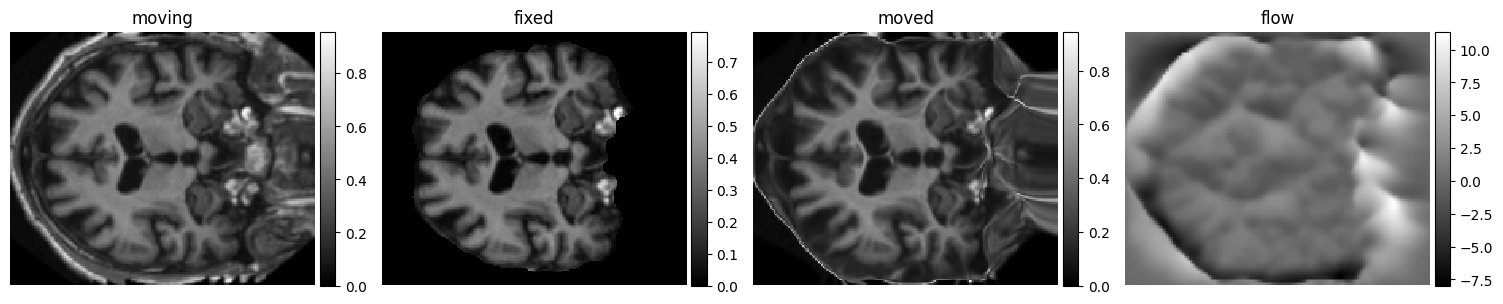

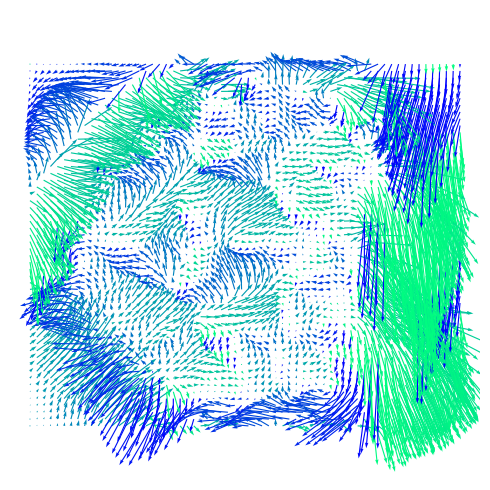

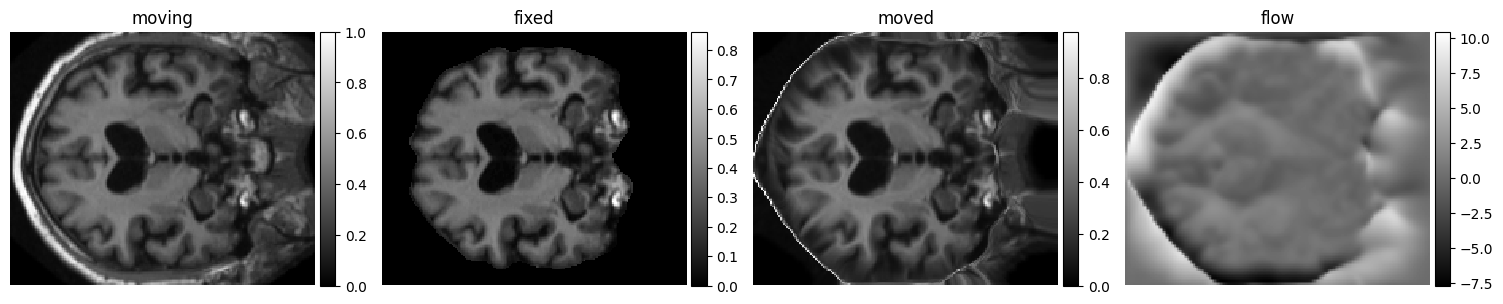

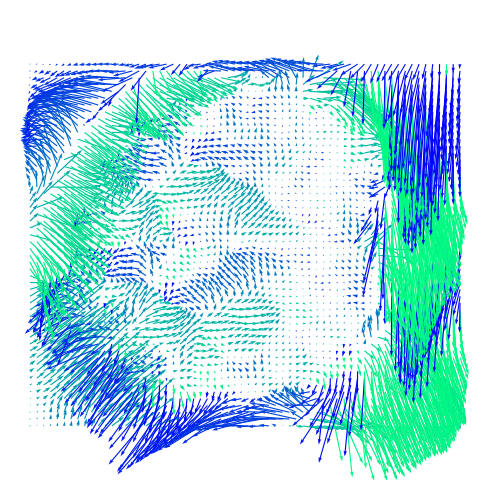

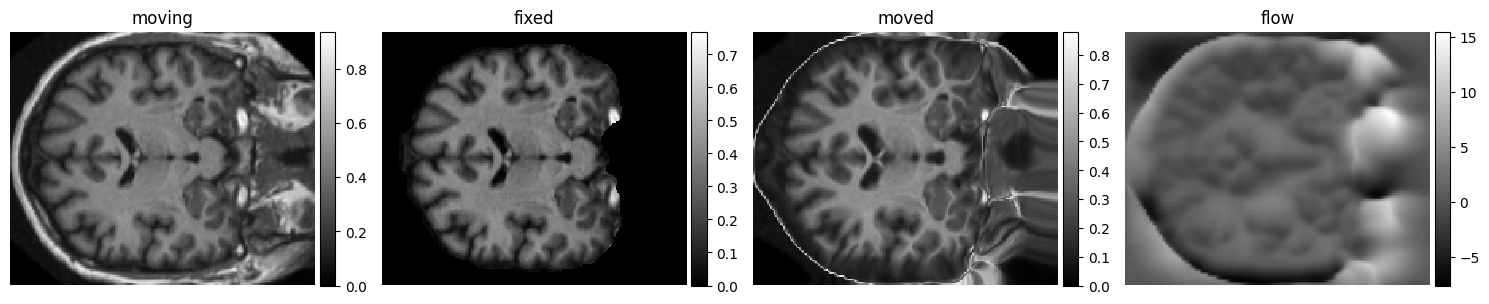

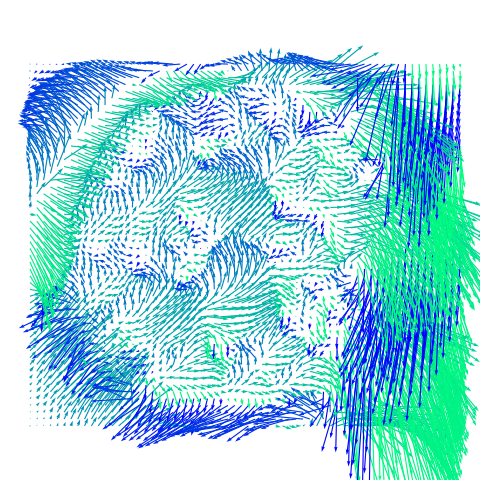

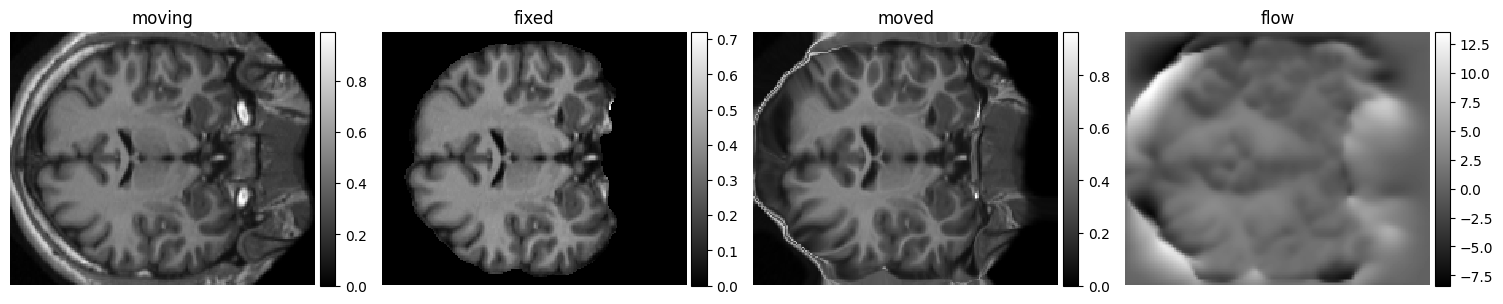

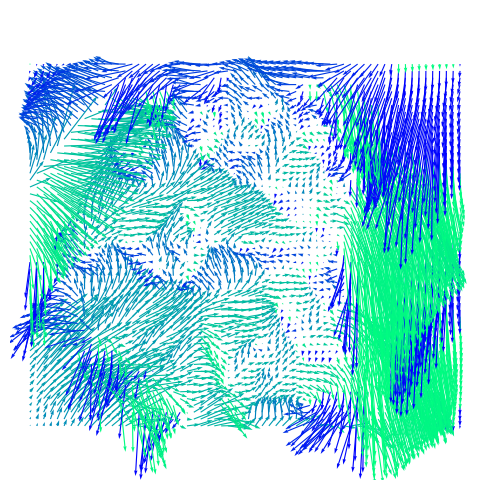

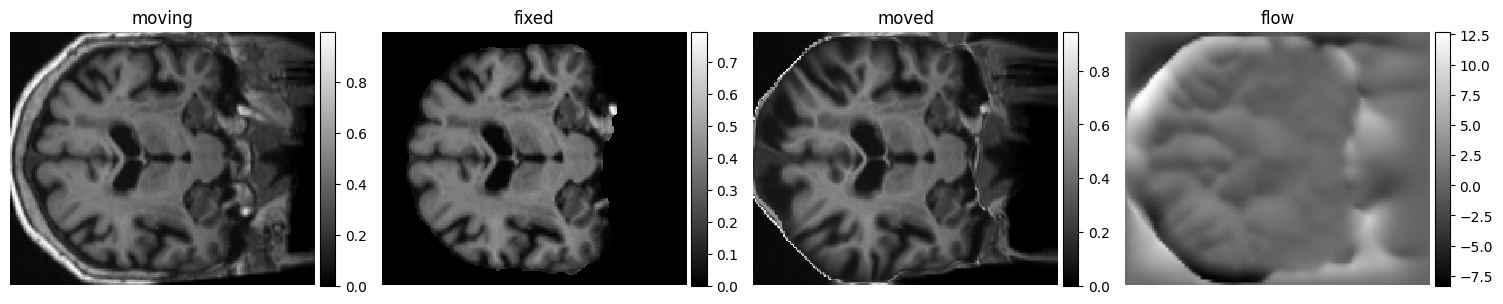

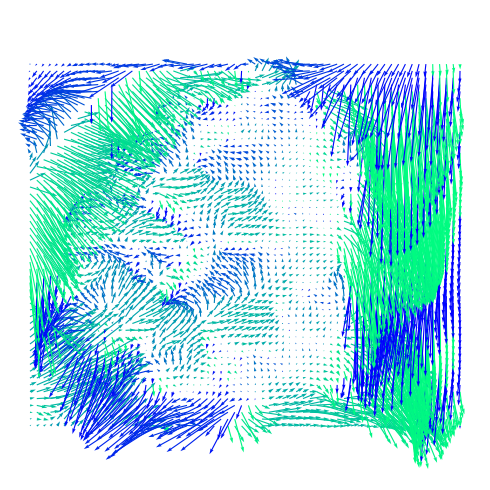

In [10]:
class Args:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

for f in validate[:5]:
  args = Args()
  args.fixed = f
  args.moving = f.replace('slice_norm', 'slice_orig')
  args.moved = 'moved.nii.gz'
  args.warp = 'warp.nii.gz'
  args.model = '/content/models/0100.h5'
  args.gpu = 0
  
  # tensorflow device handling
  device, nb_devices = vxm.tf.utils.setup_device(args.gpu)

  # load moving and fixed images
  add_feat_axis = not args.multichannel
  moving = vxm.py.utils.load_volfile(args.moving, add_batch_axis=True, add_feat_axis=add_feat_axis)

  fixed, fixed_affine = vxm.py.utils.load_volfile(
      args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

  inshape = moving.shape[1:-1]
  nb_feats = moving.shape[-1]

  with tf.device(device):
      # load model and predict
      config = dict(inshape=inshape, input_model=None)
      
      warp = vxm.networks.VxmDense.load(args.model, **config).register(moving, fixed)
      moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

  # save warp
  # if args.warp:
  #     vxm.py.utils.save_volfile(warp.squeeze(), args.warp, fixed_affine)


  # save moved image
  # vxm.py.utils.save_volfile(moved.squeeze(), args.moved, fixed_affine)

  # visualize registration between a pair of moving and fixed
  images = [img[0, :, :, 0] for img in [moving, fixed, moved, warp]]
  titles = ['moving', 'fixed', 'moved', 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

  print()

  # visualize flow
  flow = warp.squeeze()[::3,::3]
  ne.plot.flow([flow], width=5);

  print()
  print()

## Normalized (Fixed) with another Normalized (Fixed)

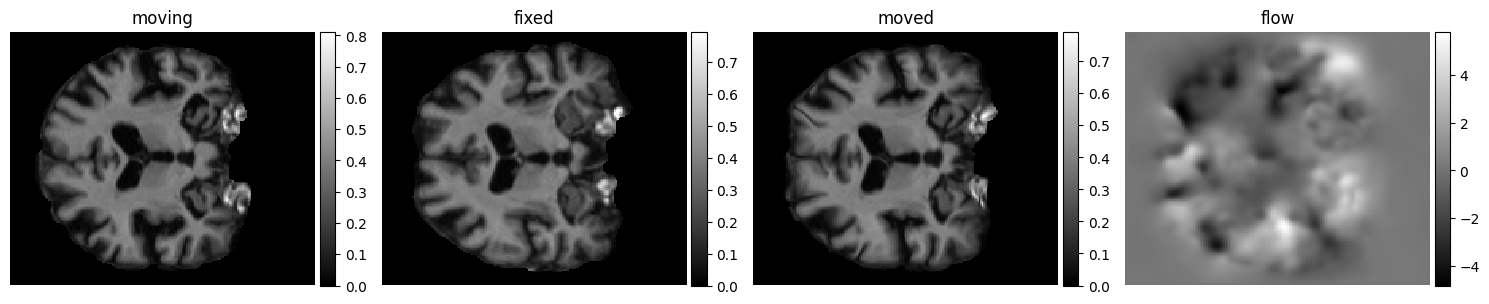

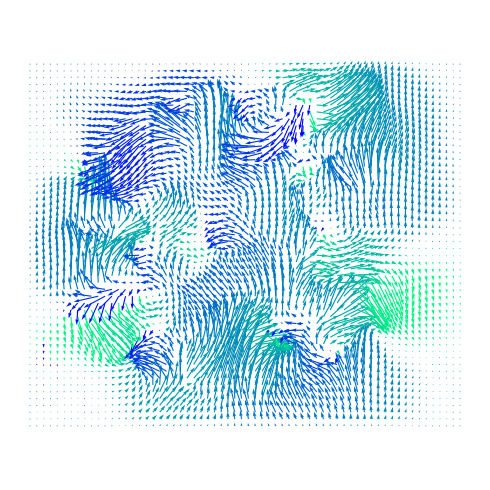

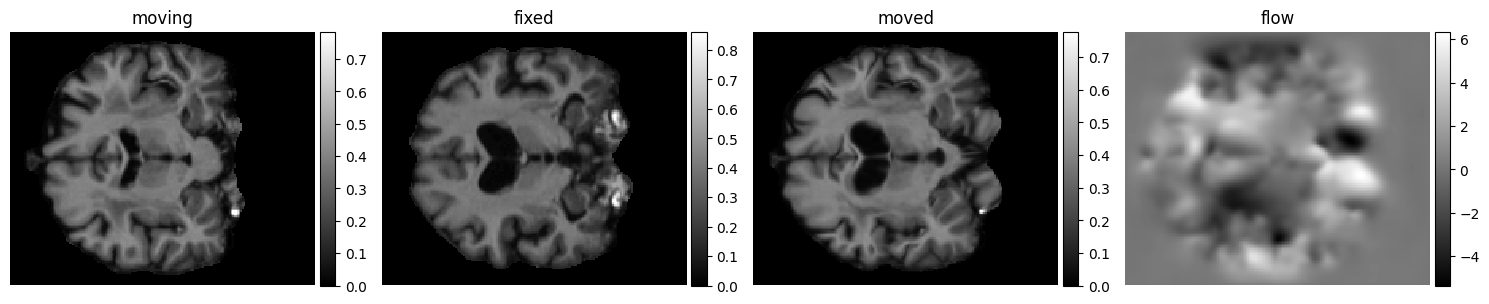

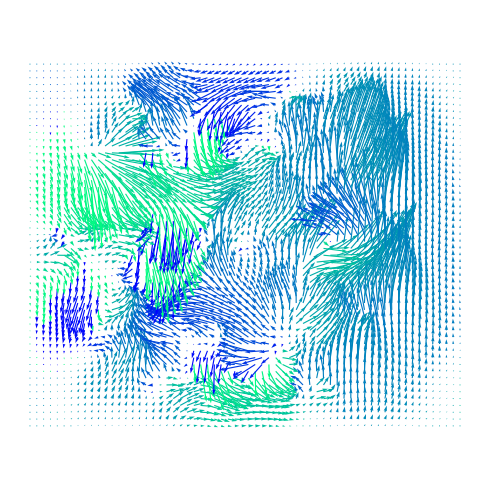

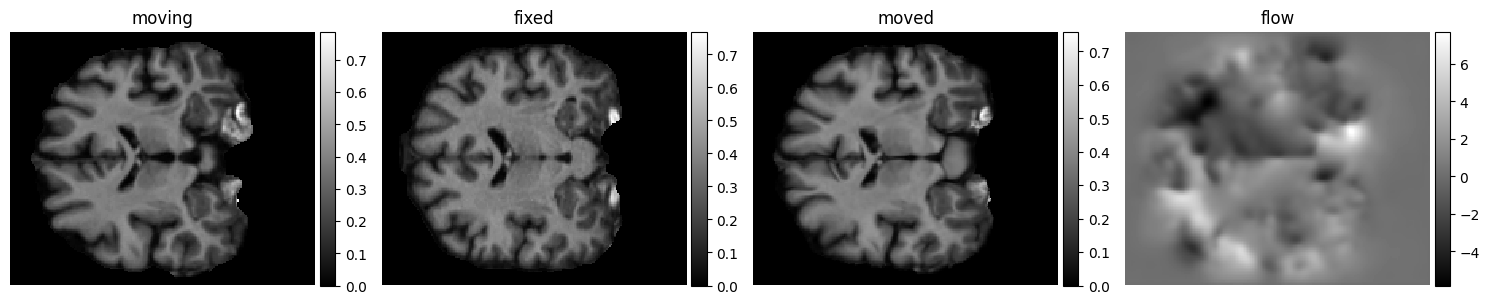

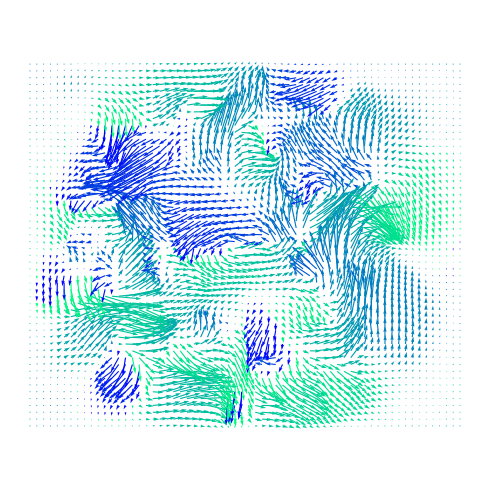

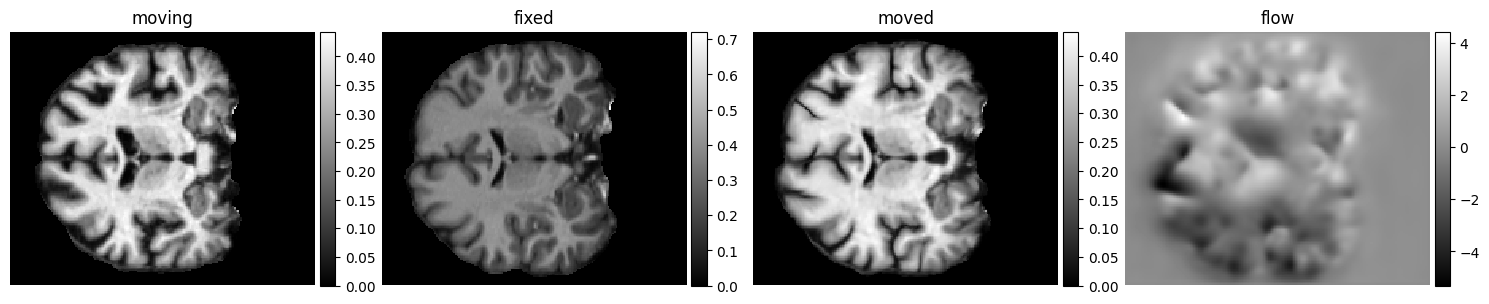

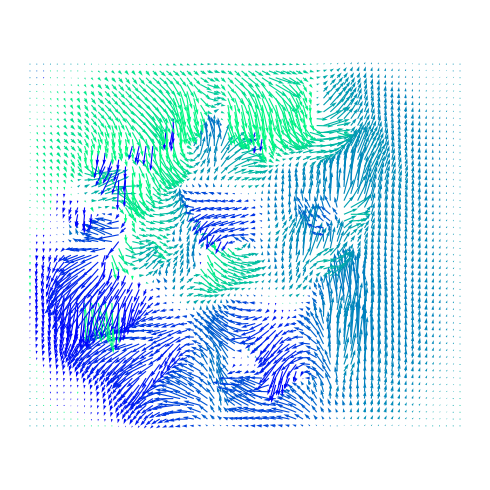

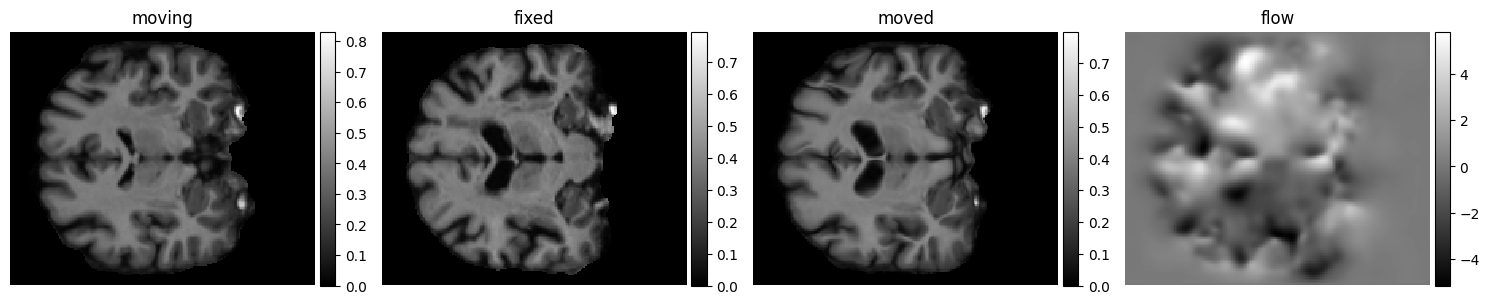

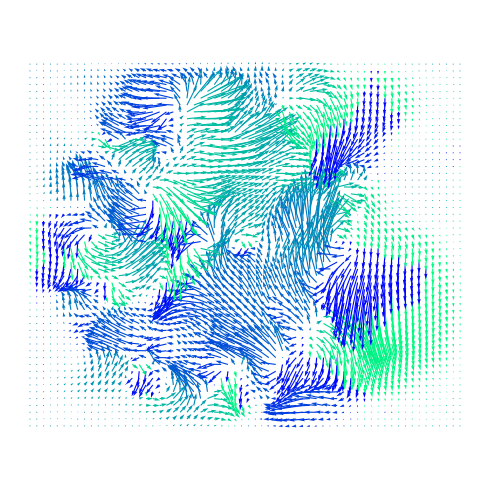

In [11]:
class Args:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

i = 5
for f in validate[:5]:
  args = Args()
  args.fixed = f
  args.moving = f.replace('slice_norm', 'slice_orig')
  args.moved = 'moved.nii.gz'
  args.warp = 'warp.nii.gz'
  args.model = '/content/models/0100.h5'
  args.gpu = 0
  
  # tensorflow device handling
  device, nb_devices = vxm.tf.utils.setup_device(args.gpu)

  # load moving and fixed images
  add_feat_axis = not args.multichannel
  moving = vxm.py.utils.load_volfile(validate[i], add_batch_axis=True, add_feat_axis=add_feat_axis)
  
  fixed, fixed_affine = vxm.py.utils.load_volfile(
      args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

  inshape = moving.shape[1:-1]
  nb_feats = moving.shape[-1]

  with tf.device(device):
      # load model and predict
      config = dict(inshape=inshape, input_model=None)
      
      warp = vxm.networks.VxmDense.load(args.model, **config).register(moving, fixed)
      moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

  # save warp
  # if args.warp:
  #     vxm.py.utils.save_volfile(warp.squeeze(), args.warp, fixed_affine)


  # save moved image
  # vxm.py.utils.save_volfile(moved.squeeze(), args.moved, fixed_affine)

  # visualize registration between a pair of moving and fixed
  images = [img[0, :, :, 0] for img in [moving, fixed, moved, warp]]
  titles = ['moving', 'fixed', 'moved', 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

  print()

  # visualize flow
  flow = warp.squeeze()[::3,::3]
  ne.plot.flow([flow], width=5);

  print()
  print()

  i = i + 1

## Normalized (Fixed) with rotate the Normalized (Fixed) by 45 degrees counter-clockwise

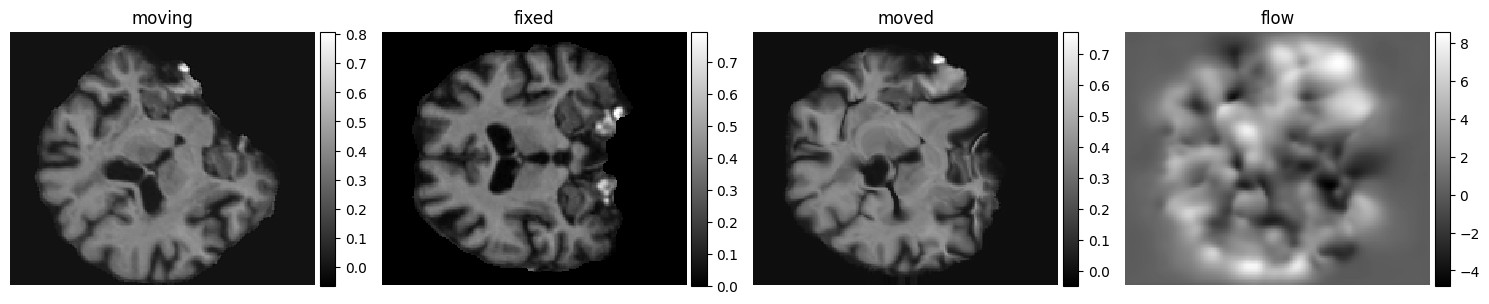

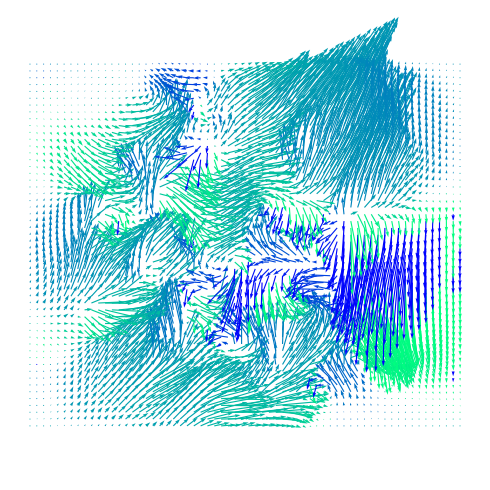

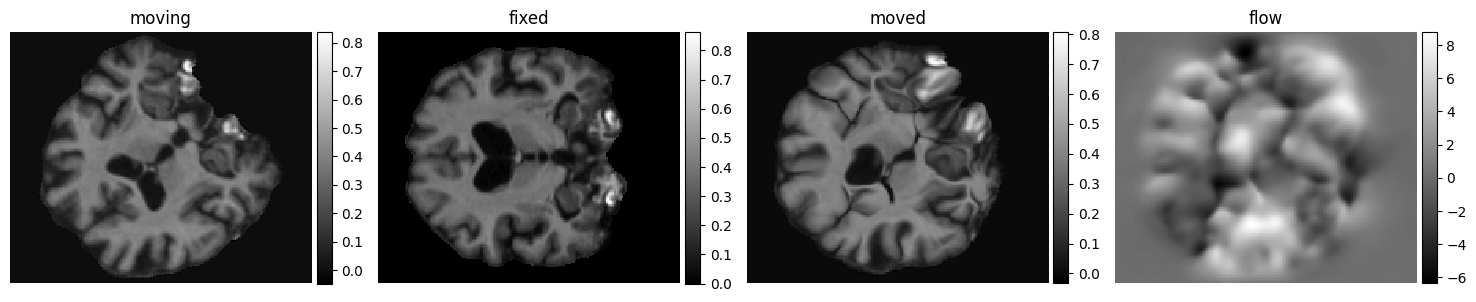

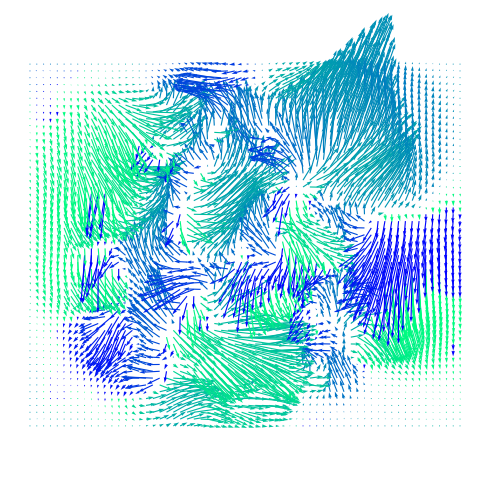

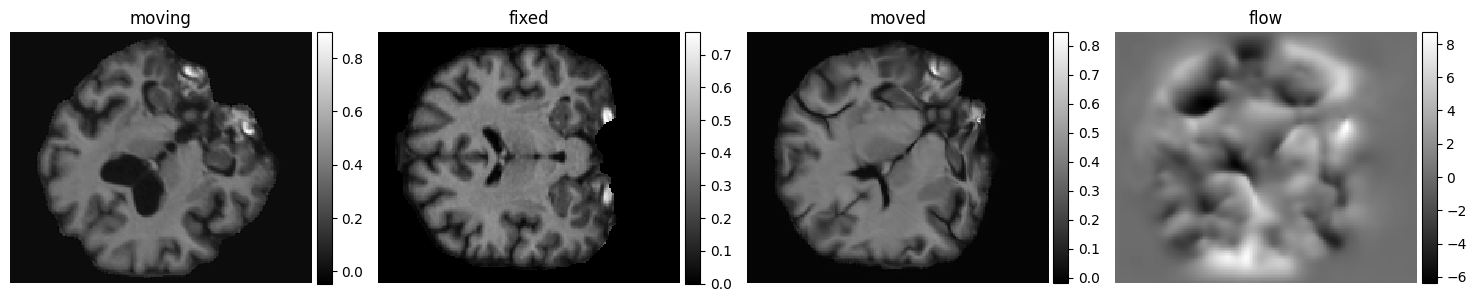

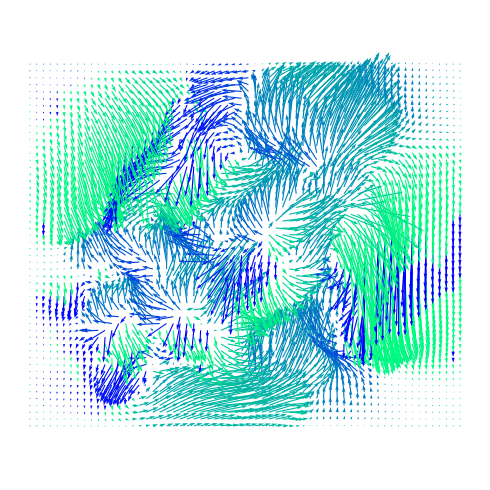

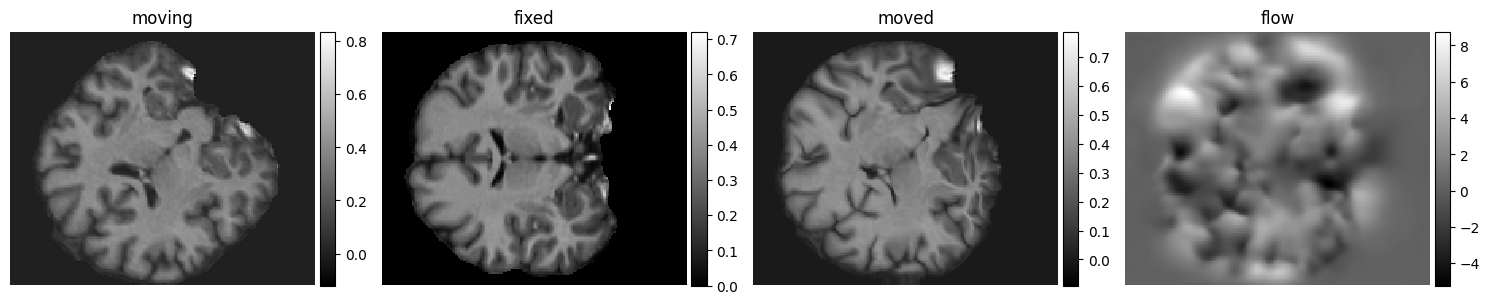

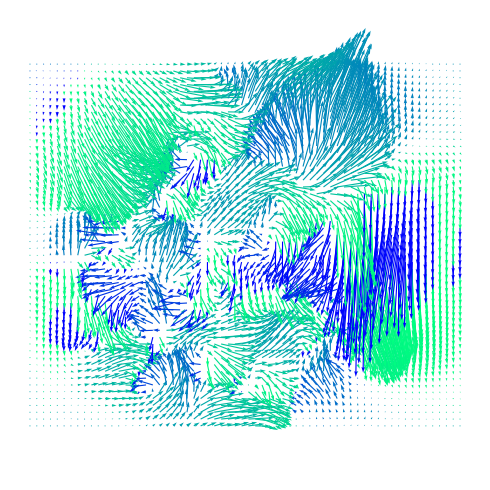

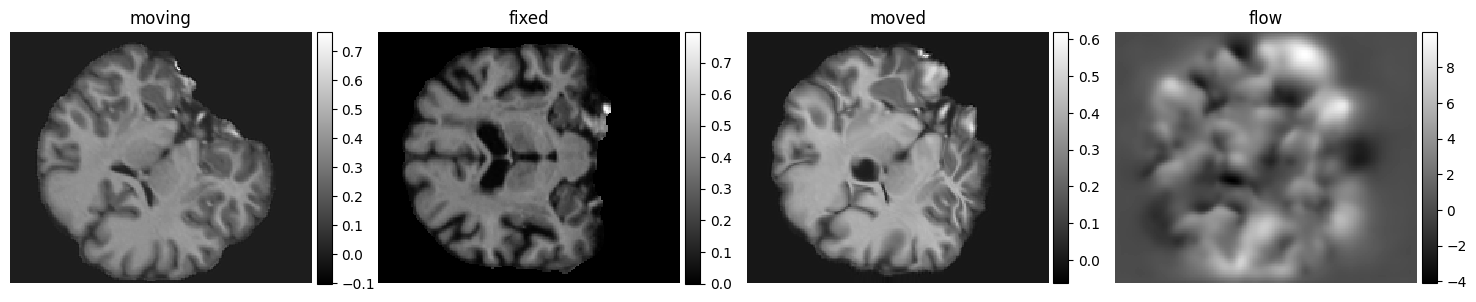

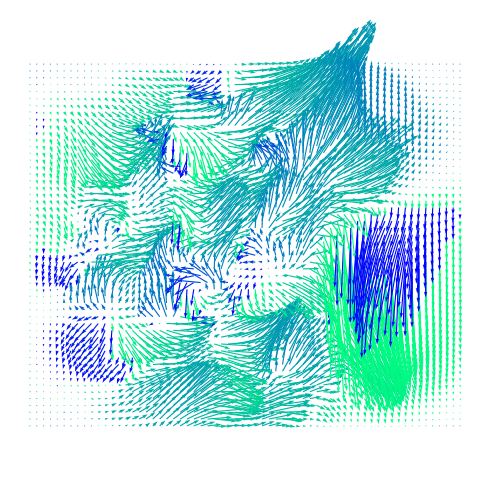

In [12]:
class Args:
  moving: str = None
  fixed: str = None
  moved: str = None
  model: str = None
  warp: str = None
  gpu: int = None
  multichannel: bool = False

for f in validate[:5]:
  args = Args()
  args.fixed = f
  args.moving = f.replace('slice_norm', 'slice_orig')
  args.moved = 'moved.nii.gz'
  args.warp = 'warp.nii.gz'
  args.model = '/content/models/0100.h5'
  args.gpu = 0
  
  # tensorflow device handling
  device, nb_devices = vxm.tf.utils.setup_device(args.gpu)

  # load moving and fixed images
  add_feat_axis = not args.multichannel

  # rotate the image by 45 degrees counter-clockwise
  moving = vxm.py.utils.load_volfile(args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis)
  moving = rotate(fixed, angle=45, axes=(1, 2), reshape=False)

  fixed, fixed_affine = vxm.py.utils.load_volfile(
      args.fixed, add_batch_axis=True, add_feat_axis=add_feat_axis, ret_affine=True)

  inshape = moving.shape[1:-1]
  nb_feats = moving.shape[-1]

  with tf.device(device):
      # load model and predict
      config = dict(inshape=inshape, input_model=None)
      
      warp = vxm.networks.VxmDense.load(args.model, **config).register(moving, fixed)
      moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])

  # save warp
  # if args.warp:
  #     vxm.py.utils.save_volfile(warp.squeeze(), args.warp, fixed_affine)


  # save moved image
  # vxm.py.utils.save_volfile(moved.squeeze(), args.moved, fixed_affine)

  # visualize registration between a pair of moving and fixed
  images = [img[0, :, :, 0] for img in [moving, fixed, moved, warp]]
  titles = ['moving', 'fixed', 'moved', 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

  print()

  # visualize flow
  flow = warp.squeeze()[::3,::3]
  ne.plot.flow([flow], width=5);

  print()
  print()

# Testing (measuring Dice scores)

## Normalized (Fixed) with Original (Moving)

In [13]:
# keep track of all dice scores
reg_times = []
dice_means = []

img_pairs = []
seg_pairs = []

class Args:
  model: str = None
  labels = None

args = Args()
args.model = '/content/models/0100.h5'

labels = np.load(args.labels) if args.labels else None

for f in validate[:5]:
  img_pairs.append([f, f.replace('slice_norm', 'slice_orig')])
  seg_pairs.append([f.replace('slice_norm', 'slice_seg24'), f.replace('slice_norm', 'slice_seg24')])

with tf.device(device):
    # load model and build nearest-neighbor transfer model
    model = vxm.networks.VxmDense.load(args.model, input_model=None)
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

    for i in range(len(img_pairs)):

        # load moving image and seg
        moving_vol = vxm.py.utils.load_volfile(
            img_pairs[i][0], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        moving_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][0], np_var='seg', add_batch_axis=True, add_feat_axis=add_feat_axis)

        # load fixed image and seg
        fixed_vol = vxm.py.utils.load_volfile(
            img_pairs[i][1], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        fixed_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][1], np_var='seg')

        # predict warp and time
        start = time.time()
        warp = registration_model.predict([moving_vol, fixed_vol])
        reg_time = time.time() - start
        if i != 0:
            # first keras prediction is generally rather slow
            reg_times.append(reg_time)

        # apply transform
        warped_seg = transform_model.predict([moving_seg, warp]).squeeze()

        # compute volume overlap (dice)
        overlap = vxm.py.utils.dice(warped_seg, fixed_seg, labels=labels)
        dice_means.append(np.mean(overlap))
        print('Pair %d    Reg Time: %.4f    Dice: %.4f +/- %.4f' % (i + 1, reg_time,
                                                                    np.mean(overlap),
                                                                    np.std(overlap)))

print()
print('Avg Reg Time: %.4f +/- %.4f  (skipping first prediction)' % (np.mean(reg_times),
                                                                    np.std(reg_times)))
print('Avg Dice: %.4f +/- %.4f' % (np.mean(dice_means), np.std(dice_means)))

Pair 1    Reg Time: 16.5535    Dice: 0.7156 +/- 0.2170
Pair 2    Reg Time: 0.0130    Dice: 0.8528 +/- 0.1245
Pair 3    Reg Time: 0.0119    Dice: 0.6502 +/- 0.2650
Pair 4    Reg Time: 0.0146    Dice: 0.7489 +/- 0.1584
Pair 5    Reg Time: 0.0122    Dice: 0.8243 +/- 0.1606

Avg Reg Time: 0.0129 +/- 0.0011  (skipping first prediction)
Avg Dice: 0.7584 +/- 0.0733


## Normalized (Fixed) with another Normalized (Fixed)

In [14]:
# keep track of all dice scores
reg_times = []
dice_means = []

img_pairs = []
seg_pairs = []

class Args:
  model: str = None
  labels = None

args = Args()
args.model = '/content/models/0100.h5'

labels = np.load(args.labels) if args.labels else None

i = 5
for f in validate[:5]:
  img_pairs.append([f, validate[i]])
  seg_pairs.append([f.replace('slice_norm', 'slice_seg24'), validate[i].replace('slice_norm', 'slice_seg24')])
  i = i + 1

with tf.device(device):
    # load model and build nearest-neighbor transfer model
    model = vxm.networks.VxmDense.load(args.model, input_model=None)
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

    for i in range(len(img_pairs)):

        # load moving image and seg
        moving_vol = vxm.py.utils.load_volfile(
            img_pairs[i][0], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        moving_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][0], np_var='seg', add_batch_axis=True, add_feat_axis=add_feat_axis)

        # load fixed image and seg
        fixed_vol = vxm.py.utils.load_volfile(
            img_pairs[i][1], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        fixed_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][1], np_var='seg')

        # predict warp and time
        start = time.time()
        warp = registration_model.predict([moving_vol, fixed_vol])
        reg_time = time.time() - start
        if i != 0:
            # first keras prediction is generally rather slow
            reg_times.append(reg_time)

        # apply transform
        warped_seg = transform_model.predict([moving_seg, warp]).squeeze()

        # compute volume overlap (dice)
        overlap = vxm.py.utils.dice(warped_seg, fixed_seg, labels=labels)
        dice_means.append(np.mean(overlap))
        print('Pair %d    Reg Time: %.4f    Dice: %.4f +/- %.4f' % (i + 1, reg_time,
                                                                    np.mean(overlap),
                                                                    np.std(overlap)))

print()
print('Avg Reg Time: %.4f +/- %.4f  (skipping first prediction)' % (np.mean(reg_times),
                                                                    np.std(reg_times)))
print('Avg Dice: %.4f +/- %.4f' % (np.mean(dice_means), np.std(dice_means)))

Pair 1    Reg Time: 17.7346    Dice: 0.7139 +/- 0.2163
Pair 2    Reg Time: 0.0124    Dice: 0.5916 +/- 0.2734
Pair 3    Reg Time: 0.0132    Dice: 0.7031 +/- 0.2354
Pair 4    Reg Time: 0.0117    Dice: 0.7081 +/- 0.2166
Pair 5    Reg Time: 0.0124    Dice: 0.6623 +/- 0.2647

Avg Reg Time: 0.0124 +/- 0.0005  (skipping first prediction)
Avg Dice: 0.6758 +/- 0.0459


## Normalized (Fixed) with rotate the Normalized (Fixed) by 45 degrees counter-clockwise

In [15]:
# keep track of all dice scores
reg_times = []
dice_means = []

img_pairs = []
seg_pairs = []

class Args:
  model: str = None
  labels = None

args = Args()
args.model = '/content/models/0100.h5'

labels = np.load(args.labels) if args.labels else None

for f in validate[:5]:
  img_pairs.append([f])
  seg_pairs.append([f.replace('slice_norm', 'slice_seg24')])

with tf.device(device):
    # load model and build nearest-neighbor transfer model
    model = vxm.networks.VxmDense.load(args.model, input_model=None)
    registration_model = model.get_registration_model()
    inshape = registration_model.inputs[0].shape[1:-1]
    transform_model = vxm.networks.Transform(inshape, interp_method='nearest')

    for i in range(len(img_pairs)):

        # load moving image and seg
        moving_vol = vxm.py.utils.load_volfile(
            img_pairs[i][0], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        moving_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][0], np_var='seg', add_batch_axis=True, add_feat_axis=add_feat_axis)

        moving_vol = rotate(moving_vol, angle=45, axes=(1, 2), reshape=False)
        moving_seg = rotate(moving_seg, angle=45, axes=(1, 2), reshape=False)

        # load fixed image and seg
        fixed_vol = vxm.py.utils.load_volfile(
            img_pairs[i][0], np_var='vol', add_batch_axis=True, add_feat_axis=add_feat_axis)
        fixed_seg = vxm.py.utils.load_volfile(
            seg_pairs[i][0], np_var='seg')

        # predict warp and time
        start = time.time()
        warp = registration_model.predict([moving_vol, fixed_vol])
        reg_time = time.time() - start
        if i != 0:
            # first keras prediction is generally rather slow
            reg_times.append(reg_time)

        # apply transform
        warped_seg = transform_model.predict([moving_seg, warp]).squeeze()

        # compute volume overlap (dice)
        overlap = vxm.py.utils.dice(warped_seg, fixed_seg, labels=labels)
        dice_means.append(np.mean(overlap))
        print('Pair %d    Reg Time: %.4f    Dice: %.4f +/- %.4f' % (i + 1, reg_time,
                                                                    np.mean(overlap),
                                                                    np.std(overlap)))

print()
print('Avg Reg Time: %.4f +/- %.4f  (skipping first prediction)' % (np.mean(reg_times),
                                                                    np.std(reg_times)))
print('Avg Dice: %.4f +/- %.4f' % (np.mean(dice_means), np.std(dice_means)))

Pair 1    Reg Time: 18.4922    Dice: 0.1326 +/- 0.1996
Pair 2    Reg Time: 0.0121    Dice: 0.1107 +/- 0.1675
Pair 3    Reg Time: 0.0108    Dice: 0.1056 +/- 0.1672
Pair 4    Reg Time: 0.0113    Dice: 0.1156 +/- 0.1702
Pair 5    Reg Time: 0.0108    Dice: 0.1240 +/- 0.1761

Avg Reg Time: 0.0113 +/- 0.0005  (skipping first prediction)
Avg Dice: 0.1177 +/- 0.0096


# Run scripts

In [ ]:
# write a list of OASIS subjects to a training file
import pathlib
path = pathlib.Path('/content/OASIS')
subj_lst_m = [str(f/'slice_norm.nii.gz') for f in path.iterdir() if str(f).endswith('MR1')]
with open('train_list.txt','w') as tfile:
	tfile.write('\n'.join(subj_lst_m))

In [ ]:
%run -i /content/voxelmorph/scripts/tf/train.py \
--img-list 'train_list.txt' \
--epochs 100

In [ ]:
%run /content/voxelmorph/scripts/tf/register.py \
--moving /content/OASIS/OASIS_OAS1_0001_MR1/slice_orig.nii.gz \
--fixed /content/OASIS/OASIS_OAS1_0001_MR1/slice_norm.nii.gz \
--moved moved.nii.gz \
--warp warp.nii.gz \
--model /content/models/0100.h5 \
--gpu 0

In [ ]:
%run -i /content/voxelmorph/scripts/tf/test.py \
--model /content/models/0100.h5 \
--pairs /content/pairs.txt \
--img-prefix /content/OASIS/ \
--seg-prefix /content/OASIS/ \
--img-suffix /slice_norm.nii.gz \
--seg-suffix /slice_seg24.nii.gz

# Some annotations

Explain of testing script:

https://github.com/voxelmorph/voxelmorph/issues/373